In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import sbibm
from sbibm.tasks.gaussian_linear.task import GaussianLinear
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import pickle
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)

Device: cpu


In [3]:
n_posterior_samples = 2000

class DistanceEvaluator:
    def __init__(self, simulator, param_ranges, task):
        self.simulator = simulator
        self.param_ranges = param_ranges
        self.task = task
        self.dim = len(param_ranges)
        self.prior_center = np.array([(low + high) / 2 for low, high in param_ranges])
        # Standard deviation per dimension for uniform distribution: (b-a)/sqrt(12)
        self.sigma = np.mean([(high - low) / np.sqrt(12) for low, high in param_ranges])
        self.max_radius = min([(high - low) / 2 for low, high in param_ranges])

    def sample_on_sphere(self, n_points, radius, dim):
        """Sample points uniformly on a sphere of given radius in d dimensions"""
        if radius == 0:
            return np.array([self.prior_center])
        
        # Generate points from standard normal distribution
        points = np.random.randn(n_points, dim)
        # Normalize to unit sphere
        norms = np.linalg.norm(points, axis=1, keepdims=True)
        points = points / norms
        # Scale to desired radius
        points = points * radius
        # Translate to prior center
        points = points + self.prior_center
        
        # Filter points that fall within prior bounds
        valid_points = []
        for point in points:
            if all(self.param_ranges[i][0] <= point[i] <= self.param_ranges[i][1] 
                   for i in range(self.dim)):
                valid_points.append(point)
        
        return np.array(valid_points)

    def create_test_points(self, n_points_per_radius=50):
        """Create test points at different distance bins (center, 1σ, 2σ, 3σ)"""
        test_points = []
        distance_bins = []
        distance_labels = ['center', '1sigma', '2sigma', '3sigma']
        
        # Distance bins based on sigma, but cap at max_radius
        radii = [0.0, 1.0 * self.sigma, 2.0 * self.sigma, min(3.0 * self.sigma, self.max_radius * 0.9)]
        
        for radius, label in zip(radii, distance_labels):
            if radius == 0:
                # Center point
                test_points.append(self.prior_center.copy())
                distance_bins.append(label)
            else:
                # Sample points on sphere at this radius
                attempts = 0
                max_attempts = 20  # Increased attempts for better coverage
                points_at_radius = []
                
                while len(points_at_radius) < n_points_per_radius and attempts < max_attempts:
                    # Sample more points than needed to account for filtering
                    new_points = self.sample_on_sphere(
                        n_points_per_radius * 3, radius, self.dim
                    )
                    if len(new_points) > 0:
                        points_at_radius.extend(new_points)
                    attempts += 1
                
                # Take only the requested number of points
                points_at_radius = points_at_radius[:n_points_per_radius]
                
                # Add warning if we couldn't get enough points
                if len(points_at_radius) < n_points_per_radius:
                    print(f"Warning: Only got {len(points_at_radius)}/{n_points_per_radius} points for {label} (radius={radius:.3f})")
                
                for point in points_at_radius:
                    test_points.append(point)
                    distance_bins.append(label)
        
        return np.array(test_points), np.array(distance_bins)

    def evaluate_all(self, posterior_dict, test_points, n_samples=n_posterior_samples):
        """Evaluate all posteriors including reference"""
        observations = []
        results = {'test_points': test_points}
        
        # Generate observations
        for theta in tqdm(test_points, desc="Generating observations"):
            x_obs = self.simulator(torch.tensor(theta, dtype=torch.float32))
            observations.append(x_obs)
        
        results['observations'] = observations
        
        # Reference posteriors
        ref_samples = []
        for x_obs in tqdm(observations, desc="Reference"):
            ref_post = self.task._get_reference_posterior(observation=x_obs.unsqueeze(0))
            ref_samples.append(ref_post.sample((n_samples,)).cpu().numpy())
        results['Reference'] = ref_samples
        
        # Learned posteriors
        for name, posterior in posterior_dict.items():
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples
        
        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss
        
        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

In [4]:
# Load all models from experiment-models folder
dimensions = [4, 8, 12, 16, 20]

all_posteriors = {}

# Load both uniform and tailed models for each dimension
for dim in dimensions:
    # Load uniform model
    uniform_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/dim-{dim}/uniform/posterior.pkl'
    try:
        with open(uniform_path, 'rb') as f:
            posterior = pickle.load(f)
            key = f'Uniform-D={dim}'
            all_posteriors[key] = posterior
            print(f"Loaded: {key}")
    except FileNotFoundError:
        print(f"Not found: {uniform_path}")
    
    # Load tailed model
    tailed_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/dim-{dim}/tailed/posterior.pkl'
    try:
        with open(tailed_path, 'rb') as f:
            posterior = pickle.load(f)
            key = f'Tailed-D={dim}'
            all_posteriors[key] = posterior
            print(f"Loaded: {key}")
    except FileNotFoundError:
        print(f"Not found: {tailed_path}")

print(f"\nTotal models loaded: {len(all_posteriors)}")

Loaded: Uniform-D=4
Loaded: Tailed-D=4
Loaded: Uniform-D=8
Loaded: Tailed-D=8
Loaded: Uniform-D=12
Loaded: Tailed-D=12
Loaded: Uniform-D=16
Loaded: Tailed-D=16
Loaded: Uniform-D=20
Loaded: Tailed-D=20

Total models loaded: 10


### Evaluate for each dimension separately
Since each dimension requires different parameter ranges and simulators, we'll evaluate them one at a time.

In [5]:
# Store results for all dimensions
all_c2st_results = {}

for dim in dimensions:
    print(f"\n{'='*80}")
    print(f"Evaluating dimension {dim}")
    print(f"{'='*80}\n")
    
    # Setup parameters and evaluator for this dimension
    param_ranges = [(-1.0, 1.0) for _ in range(dim)]
    param_width = 2.0
    
    # Task setup
    task = GaussianLinear(dim=dim, prior_scale=param_width/2)
    simulator = task.get_simulator()
    
    # Create evaluator
    evaluator = DistanceEvaluator(simulator, param_ranges, task)
    
    # Create test points (using fewer points for faster evaluation)
    test_points, distance_bins = evaluator.create_test_points(n_points_per_radius=20)
    print(f"Created {len(test_points)} test points for dimension {dim}")
    
    # Get posteriors for this dimension
    dim_posteriors = {
        f'Uniform-D={dim}': all_posteriors.get(f'Uniform-D={dim}'),
        f'Tailed-D={dim}': all_posteriors.get(f'Tailed-D={dim}')
    }
    # Remove None values
    dim_posteriors = {k: v for k, v in dim_posteriors.items() if v is not None}
    
    # Evaluate all models for this dimension
    results_all = evaluator.evaluate_all(dim_posteriors, test_points, n_samples=n_posterior_samples)
    
    # Compute C2ST vs Reference for each model
    def compute_c2st_vs_reference(results, distance_bins, evaluator):
        """Compute C2ST vs Reference for all models at each distance bin"""
        model_names = [k for k in results.keys() if k not in ['test_points', 'observations', 'Reference']]
        
        distance_bin_names = ['center', '1sigma', '2sigma', '3sigma']
        c2st_by_model_and_distance = {}
        
        for model_name in model_names:
            c2st_by_model_and_distance[model_name] = {}
            
            for bin_name in distance_bin_names:
                indices = np.where(distance_bins == bin_name)[0]
                
                if len(indices) == 0:
                    c2st_by_model_and_distance[model_name][bin_name] = []
                    continue
                
                # Compute C2ST vs Reference for this model at this distance bin
                c2st_vals = []
                for idx in indices:
                    c2st_val = evaluator.c2st(results[model_name][idx], results['Reference'][idx])
                    c2st_vals.append(c2st_val)
                
                c2st_by_model_and_distance[model_name][bin_name] = c2st_vals
        
        return c2st_by_model_and_distance
    
    c2st_results = compute_c2st_vs_reference(results_all, distance_bins, evaluator)
    
    # Store results for this dimension
    all_c2st_results[dim] = c2st_results
    
    # Show summary
    print(f"\nC2ST vs Reference Summary for D={dim}:")
    print("=" * 80)
    for model_name in sorted(c2st_results.keys()):
        print(f"\n{model_name}:")
        for bin_name in ['center', '1sigma', '2sigma', '3sigma']:
            if c2st_results[model_name][bin_name]:
                vals = np.array(c2st_results[model_name][bin_name])
                print(f"  {bin_name:8s}: {np.mean(vals):.3f} ± {np.std(vals):.3f}")


Evaluating dimension 4

Created 61 test points for dimension 4


Tailed-D=4: 100%|██████████| 61/61 [01:49<00:00,  1.79s/it]



C2ST vs Reference Summary for D=4:

Tailed-D=4:
  center  : 0.419 ± 0.000
  1sigma  : 0.445 ± 0.018
  2sigma  : 0.433 ± 0.040
  3sigma  : 0.436 ± 0.029

Uniform-D=4:
  center  : 0.482 ± 0.000
  1sigma  : 0.454 ± 0.044
  2sigma  : 0.348 ± 0.107
  3sigma  : 0.383 ± 0.089

Evaluating dimension 8

Created 61 test points for dimension 8


Tailed-D=8: 100%|██████████| 61/61 [02:37<00:00,  2.59s/it]



C2ST vs Reference Summary for D=8:

Tailed-D=8:
  center  : 0.404 ± 0.000
  1sigma  : 0.431 ± 0.020
  2sigma  : 0.420 ± 0.024
  3sigma  : 0.427 ± 0.034

Uniform-D=8:
  center  : 0.424 ± 0.000
  1sigma  : 0.437 ± 0.036
  2sigma  : 0.357 ± 0.077
  3sigma  : 0.393 ± 0.062

Evaluating dimension 12

Created 61 test points for dimension 12


Tailed-D=12: 100%|██████████| 61/61 [00:08<00:00,  7.41it/s]



C2ST vs Reference Summary for D=12:

Tailed-D=12:
  center  : 0.409 ± 0.000
  1sigma  : 0.409 ± 0.019
  2sigma  : 0.409 ± 0.020
  3sigma  : 0.396 ± 0.013

Uniform-D=12:
  center  : 0.447 ± 0.000
  1sigma  : 0.418 ± 0.032
  2sigma  : 0.395 ± 0.056
  3sigma  : 0.385 ± 0.063

Evaluating dimension 16

Created 61 test points for dimension 16


Tailed-D=16: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



C2ST vs Reference Summary for D=16:

Tailed-D=16:
  center  : 0.379 ± 0.000
  1sigma  : 0.375 ± 0.017
  2sigma  : 0.385 ± 0.028
  3sigma  : 0.387 ± 0.009

Uniform-D=16:
  center  : 0.429 ± 0.000
  1sigma  : 0.407 ± 0.023
  2sigma  : 0.367 ± 0.054
  3sigma  : 0.408 ± 0.020

Evaluating dimension 20

Created 61 test points for dimension 20


Tailed-D=20: 100%|██████████| 61/61 [00:17<00:00,  3.43it/s]



C2ST vs Reference Summary for D=20:

Tailed-D=20:
  center  : 0.383 ± 0.000
  1sigma  : 0.356 ± 0.025
  2sigma  : 0.360 ± 0.022
  3sigma  : 0.366 ± 0.026

Uniform-D=20:
  center  : 0.418 ± 0.000
  1sigma  : 0.392 ± 0.034
  2sigma  : 0.378 ± 0.041
  3sigma  : 0.386 ± 0.032


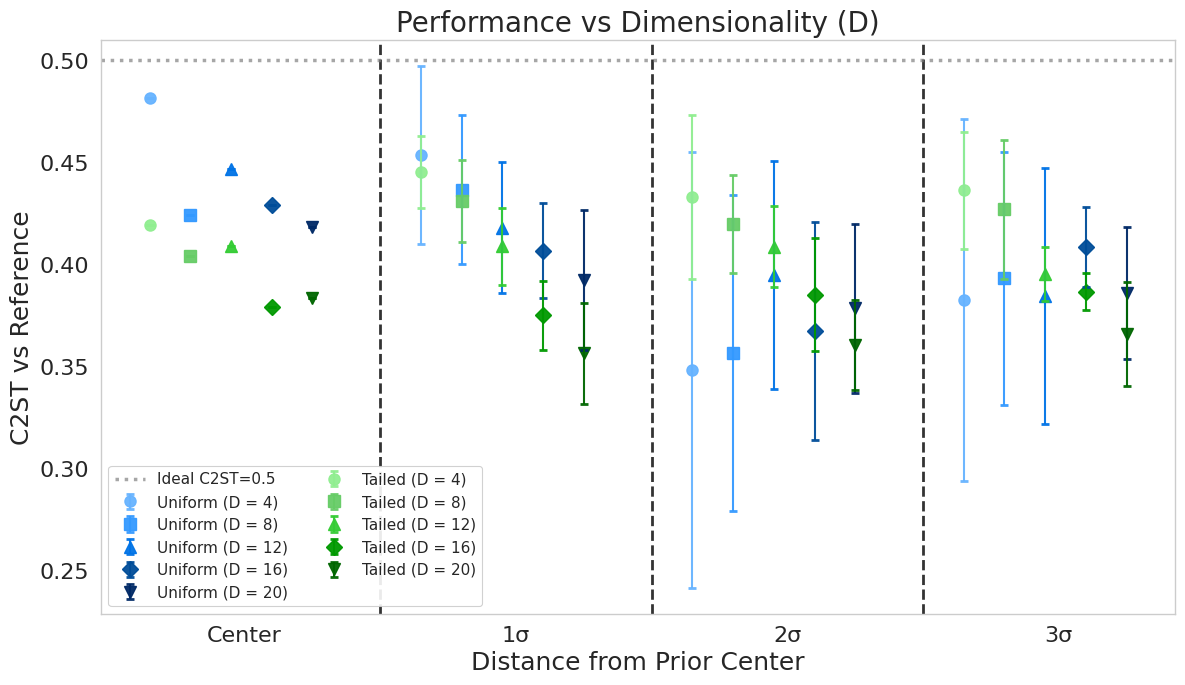

In [10]:
def plot_c2st_vs_distance_by_dimension(all_c2st_results, dimensions, figsize=(12, 7)):
    """Plot C2ST vs distance for all dimensions in a single plot"""
    distance_bins = ['center', '1sigma', '2sigma', '3sigma']
    bin_labels = ['Center', '1σ', '2σ', '3σ']
    x_positions = np.arange(len(distance_bins))

    plt.figure(figsize=figsize)

    # Define colors and markers for different dimensions (wider spread)
    # Uniform models - shades of blue
    uniform_styles = {
        4: {'color': '#66b3ff', 'marker': 'o', 'linestyle': '-', 'offset': -0.35},
        8: {'color': '#3399ff', 'marker': 's', 'linestyle': '-', 'offset': -0.2},
        12: {'color': '#0073e6', 'marker': '^', 'linestyle': '-', 'offset': -0.05},
        16: {'color': '#004d99', 'marker': 'D', 'linestyle': '-', 'offset': 0.1},
        20: {'color': '#002966', 'marker': 'v', 'linestyle': '-', 'offset': 0.25}
    }

    # Tailed models - shades of green
    tailed_styles = {
        4: {'color': '#90ee90', 'marker': 'o', 'linestyle': '--', 'offset': -0.35},
        8: {'color': '#66cc66', 'marker': 's', 'linestyle': '--', 'offset': -0.2},
        12: {'color': '#33cc33', 'marker': '^', 'linestyle': '--', 'offset': -0.05},
        16: {'color': '#009900', 'marker': 'D', 'linestyle': '--', 'offset': 0.1},
        20: {'color': '#006600', 'marker': 'v', 'linestyle': '--', 'offset': 0.25}
    }

    # Plot Uniform models
    for dim in dimensions:
        model_name = f'Uniform-D={dim}'
        if dim in all_c2st_results and model_name in all_c2st_results[dim]:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if all_c2st_results[dim][model_name][bin_name]:  # Check if bin has data
                    vals = np.array(all_c2st_results[dim][model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + uniform_styles[dim]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = uniform_styles[dim]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Uniform (D = {dim})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Plot Tailed models
    for dim in dimensions:
        model_name = f'Tailed-D={dim}'
        if dim in all_c2st_results and model_name in all_c2st_results[dim]:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if all_c2st_results[dim][model_name][bin_name]:  # Check if bin has data
                    vals = np.array(all_c2st_results[dim][model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + tailed_styles[dim]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = tailed_styles[dim]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Tailed (D = {dim})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Add vertical dashed lines between distance bins
    for i in range(len(x_positions) - 1):
        separator_x = (x_positions[i] + x_positions[i + 1]) / 2
        plt.axvline(separator_x, color='black', linestyle='--', linewidth=2.0, alpha=0.8, zorder=0)

    plt.axhline(0.5, color='gray', linestyle=':', linewidth=2.5, label='Ideal C2ST=0.5', alpha=0.7)
    plt.xticks(x_positions, bin_labels, fontsize=16)
    plt.xlabel('Distance from Prior Center', fontsize=18)
    plt.ylabel('C2ST vs Reference', fontsize=18)
    plt.title('Performance vs Dimensionality (D)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=11, loc='best', ncol=2, framealpha=0.9)
    plt.grid(False)
    plt.tight_layout()

    return plt.gcf()

# Create the single plot version
sns.set(style="whitegrid", context="paper", font_scale=1.2)
fig = plot_c2st_vs_distance_by_dimension(all_c2st_results, dimensions)
plt.show()